In [1]:
import torch
import deepspeed
from wraptrain import ReadImage,OriginModNetDataLoader,ImageMatteLoader,ModNetImageGenerator,NetTrainer

[2024-04-04 15:28:18,397] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-04 15:28:25.870474: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 15:28:25.918356: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 15:28:25.918387: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 15:28:25.918412: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alrea

In [2]:
base_path = "/mnt/data/Test/"
fg = base_path+"Comp"
matte= base_path+"Alpha"
files = ReadImage(fg,matte).read_same_names()

In [3]:
files.shape

(2250, 2)

In [4]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from  src.models.finitenetsmall import FiniteNet
#small=oo.FiniteNet()
def visualize_keypoints(image_path,keypoints):
    # 加载预训练的关键点检测模型
    #model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
   # model.eval()  # 将模型设置为评估模式
    
    # 图像预处理
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # 加载图像
    if type(image_path) == str:
        image = Image.open(image_path).convert("RGB")
    else:
        image = image_path
    
    image_tensor = transform(image).unsqueeze(0)  # 添加批次维度
    #print(image_tensor.shape)
    # 可视化
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    #print(predictions[1][0].shape)
    #print(predictions[1][0])
    if True:
         # 获取第一个实例的关键点
        #scores = predictions[0]['scores'][0]  # 获取第一个实例的分数，可用于过滤
        
        for kpt in keypoints:
            x, y, confidence = kpt
            if confidence > 0.8:  # 可根据需要调整置信度阈值
                circle = patches.Circle((x, y), radius=2, edgecolor='r', facecolor='red')
                ax.add_patch(circle)
    
    plt.axis('off')  # 不显示坐标轴
    plt.show()

In [5]:
import importlib
import torch
import  src.models.finitenetsmall as oo
import wraptrain
#import wraptrain.OriginModNetDataLoader as imgloader
# 重新载入包含 FiniteNet 类的模块
importlib.reload(wraptrain)
all_data = wraptrain.OriginModNetDataLoader(files,[512,512],hot_path=base_path+"newHeatmaps.pt")

In [6]:
shows = ImageMatteLoader(files)

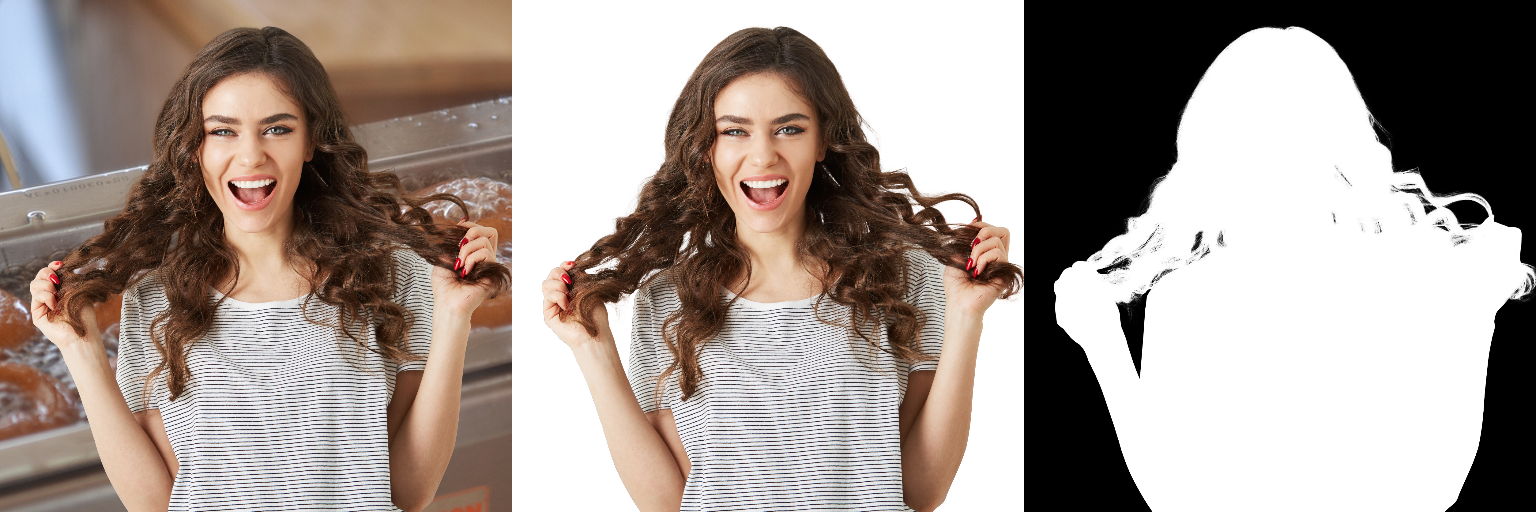

In [7]:
i=220
a=all_data[i][1]
b=all_data[i][2]
p15=shows.show(i,[512,512])[0]

In [10]:
type(p15)

PIL.Image.Image

/mnt/data/Test/Comp/attractive-mixed-race-male-with-positive-smile-shows-white-teeth-keeps-hands-stomach-being-high-spirit-wears-white-shirt-rejoices-positive-moments-life-people-emotions-concept_5.png


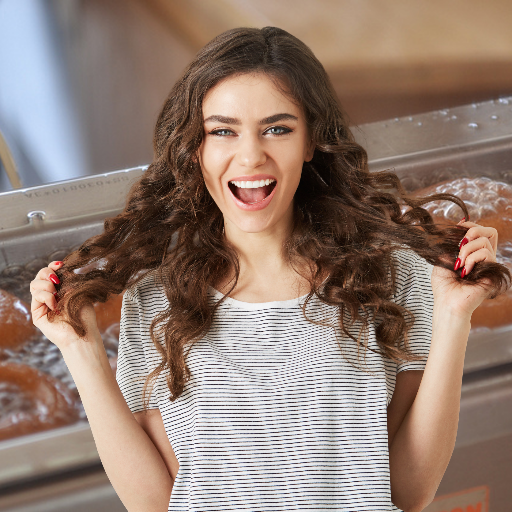

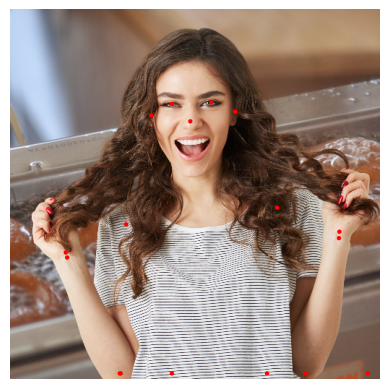

In [8]:
from torchvision import transforms

# 定义图像转换
transform = transforms.Compose([
    transforms.ToTensor(),
    # 可以添加其他的转换操作，比如归一化等
])

# 加载模型并设置为评估模式
#model = keypointrcnn_resnet50_fpn(pretrained=True).eval()
#model.cuda()
#torch.set_grad_enabled(False)
i = 135

path = files["FG"][i]
print(path)
#image = Image.open(path).convert("RGB")
image = p15
display(image)
# 对图像进行转换
image_tensor = transform(image).unsqueeze(0).cuda()  # 添加额外的维度并移动到 GPU 上

# file_name = path.split('/')[-1]  # 这行代码没有用到，可以删除

# 模型预测

visualize_keypoints(p15, a)


In [ ]:
# 示例使用更新后的模型
model = FinteNet(num_keypoints=13, pretrained=True)

# 获取不同级别的特征和关键点检测结果
#sample,fuse = model(t)

#print("KeyPoints shape:", keypoints.shape,fuse.shape)
#print([i.shape for i in model(t)])

In [ ]:
#small=oo.FiniteNet()

In [ ]:
from torch.utils.data import DataLoader
train_data = OriginModNetDataLoader(files,[512,512])
batch_size = 16 # 例如，每个批次32个样本

train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

In [13]:


import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, dataloader, epochs=1, learning_rate=1e-4, model_save_path='ownmodel.pth'):
    criterion = nn.MSELoss()  # 使用均方误差损失函数
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # 使用Adam优化器
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 检测是否有可用的GPU，若无，则使用CPU
    
    model = model.to(device)  # 确保模型在正确的设备上
    model = torch.nn.DataParallel(model)  # 使用DataParallel来利用多个GPU
    
    model.train()  # 设置模型为训练模式
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, trimaps, gt_mattes) in enumerate(dataloader):
            images = images.to(device)  # 将数据移动到当前设备上
            gt_mattes = gt_mattes.to(device)  # 同上
            
            optimizer.zero_grad()  # 清除梯度
            
            pred_matte, _,_ = model(images)  # 正向传播，忽略其他两个输出
            
            loss = criterion(pred_matte, gt_mattes)  # 计算损失
            
            loss.backward()  # 反向传播
            optimizer.step()  # 优化器更新模型参数
            
            running_loss += loss.item()  # 累计损失
            
            if batch_idx % 100 == 99:  # 每100个batch打印一次
                print(f'Epoch: {epoch + 1}, Batch: {batch_idx + 1}, Loss: {running_loss / 100}')
                running_loss = 0.0

    print('Training Complete')
    
    torch.save(model.state_dict(), model_save_path)  # 保存模型
    print(f'Model saved to {model_save_path}')

# 假设`model`和`train_data`已经被定义
model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))  # 首先将模型转移到正确的设备
train_model(model, train_data, epochs=10, learning_rate=1e-4, model_save_path='ownmodel.pth')



Epoch: 1, Batch: 100, Loss: 0.7105731505155564
Epoch: 2, Batch: 100, Loss: 0.6048527503013611
Epoch: 3, Batch: 100, Loss: 0.5949975144863129
Epoch: 4, Batch: 100, Loss: 0.5883784207701683
Epoch: 5, Batch: 100, Loss: 0.5854550442099571
Epoch: 6, Batch: 100, Loss: 0.586350544989109
Epoch: 7, Batch: 100, Loss: 0.5845371562242508
Epoch: 8, Batch: 100, Loss: 0.578971443772316
Epoch: 9, Batch: 100, Loss: 0.582467348575592
Epoch: 10, Batch: 100, Loss: 0.5786325287818909
Training Complete
Model saved to ownmodel.pth


In [ ]:
test = ModNetImageGenerator(files,model,ckpt_path="ownmodel.pth")

In [ ]:
pre.shape

In [23]:

from wraptrain import ReadImage,OriginModNetDataLoader,ImageMatteLoader,ModNetImageGenerator
import pandas as pd 
own = pd.DataFrame(columns=["FG","Alpha"],data=[["test01.jpg","test01.jpg"],["test02.jpg","test02.jpg"],["test03.jpg","test03.jpg"],["test04.jpg","test04.jpg"],["test05.png","test05.png"]])
owndata = ImageMatteLoader(own)

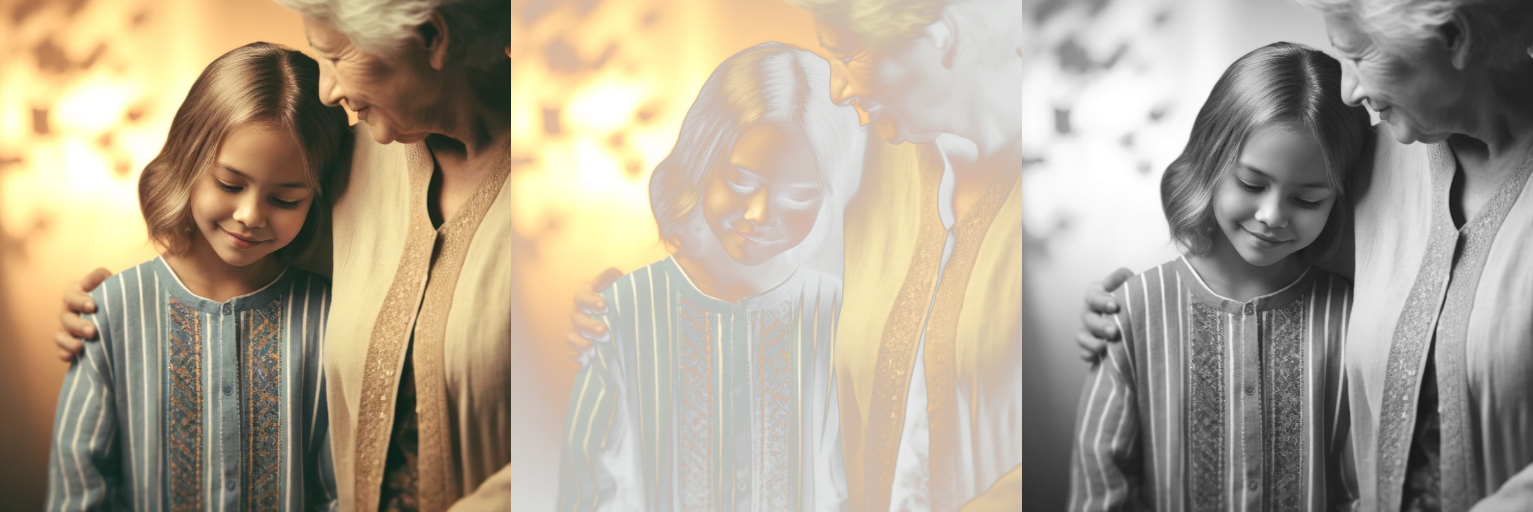

In [20]:
a = owndata.show(4,[512,512])

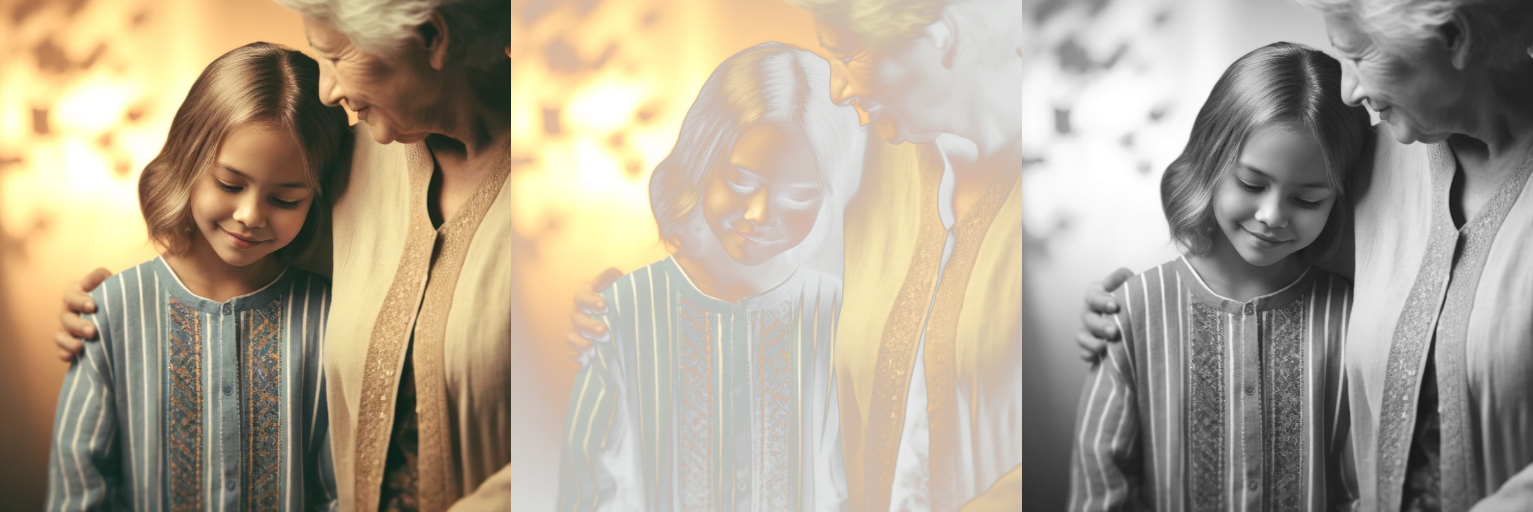

KeyError: 'test05.png'

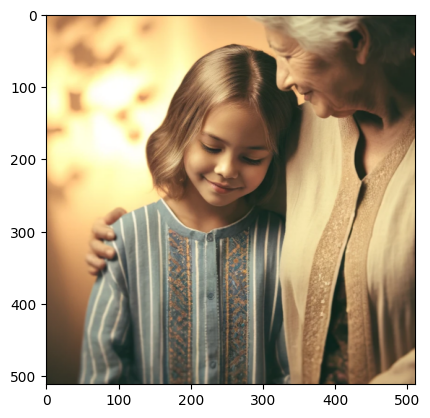

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch
i=4
fig, ax = plt.subplots(1)
ax.imshow(owndata.show(i,[512,512])[0])
all_points = torch.load("hi.pt")
# 获取预测的关键点
#keypoints = prediction[0]['keypoints']
#keypoints_scores = prediction[0]['keypoints_scores']
keypoints = all_points[f"test0{i+1}.png"]
#print(keypoints)
prediction=[1,2,3]
if len(prediction) > 0:
    # 获取第一个人体实例的关键点
    #keypoints = prediction[0]['keypoints'][0]  # 这里假设至少有一个检测到的实例
    #keypoints_scores = prediction[0]['keypoints_scores'][0]

    # 对于第一个实例，绘制所有关键点
    for j, (x, y, confidence) in enumerate(keypoints):
        if confidence > 0.8:  # 根据需要调整置信度阈值
            ax.scatter(x, y, s=50, marker='.', c='r')

plt.show()

#### 